# My Data Diary - Dashboard

Follow the steps below to generate your very own charts on your data. Have fun exploring patterns in your every day life!
- Current applications supported include: Fitbit, RescueTime, aTimeLogger

# PART I: Set Up

Steps for running this notebook on your own data
- Once you go through the steps once, the only cell you'll need to update next time is the one below specifying the date range.

**Enter Date Range OR Use X-Day Default Below**

X-Days Window from Today

In [1]:
import pandas as pd 
from datetime import date, datetime, timedelta as td

START_DATE = (datetime.now() - pd.DateOffset(days=14)).strftime("%Y-%m-%d")
END_DATE =  (datetime.now() + pd.DateOffset(days=1)).strftime("%Y-%m-%d")

Specified Time Window

In [1]:
import pandas as pd 
from datetime import date, datetime, timedelta as td

# Or define your own date range
START_DATE = '2021-02-01'
END_DATE ='2021-02-22'

In [2]:
print(f'Data from {START_DATE} through {END_DATE}, not including the latest date.')

Data from 2021-02-01 through 2021-02-22, not including the latest date.


**Load Libraries and Dependencies**

In [3]:
import os
import sys
import imp
%matplotlib inline
import json

import fitbit
# import gather_keys_oauth2 as Oauth2
import numpy as np
# import pandas as pd 
# from datetime import date, datetime, timedelta as td
import dateutil.parser
import seaborn
import time

import requests
import arrow
from requests.auth import HTTPBasicAuth


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings("ignore")

- Setup: 
    - Move file: gather_keys_oauth2.py into the python-fitbit folder
(see more info [here](https://stackoverflow.com/questions/54048327/modulenotfounderror-no-module-named-gather-keys-oauth2))


In [4]:
main_path = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
ppath = os.path.join(main_path, 'python-fitbit')
sys.path.append(ppath)

import gather_keys_oauth2 as Oauth2

**Update the files in the folder *template_my_credentials***
- Update the files in the folder with your own credentials
- Remove the *template_* prefix from the folder and individual file names
- Note: Fitbit API connection will take a couple of extra steps (see [here](https://towardsdatascience.com/collect-your-own-fitbit-data-with-python-ff145fa10873) and [here](https://github.com/markwk/qs_ledger/blob/master/fitbit/fitbit_downloader.ipynb) for helpful guides)

In [5]:
# If you stored your credentials in a different location, add the credentials path
cred_path = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
cpath = os.path.join(cred_path, 'DD')

**Retrieve this repo location path**

In [6]:
repo_path = os.getcwd()

**Load Custom Functions**
- Functions contain API data extraction & munging

In [7]:
apath = os.path.join(repo_path, 'api_data_extract')
sys.path.append(apath)

import data_pulls_fitbit as fitdp
import data_pulls_rescuetime as resdp
import data_pulls_atimelogger as logdp

- Helper functions for visualization

In [8]:
bpath = os.path.join(repo_path, 'data_prep')
sys.path.append(bpath)

import visual_prep as vp

- Check and Reload Functions

In [9]:
# # Check what paths are loaded
# print(sys.path)

# # Use below to reload custom functions without having to restart kernel
# imp.reload(fitdp)
# imp.reload(resdp)
# imp.reload(logdp)
# imp.reload(vp)

**Set figure dimensions**

In [10]:
fsize = 18
params = {
    'axes.labelsize': fsize, 
    'axes.titlesize':fsize, 
    'axes.titlepad': 20,
    'xtick.labelsize':fsize,
    'xtick.major.pad': 5, 
    'ytick.labelsize':fsize,
    'axes.labelpad': 20,
    'lines.linewidth' : 3,
    'figure.titlesize': fsize *1.5,
    'figure.figsize' : (35,8),
    'legend.title_fontsize': fsize,
    'legend.fontsize': fsize #*0.925, 
} 
plt.rcParams.update(params) 
plt.close('all')

**Using previously saved files...**
- If you are using previously saved csv files from running this report before, uncomment the code below and update the dates
- Then skip to the **Expand Dataset & Visualize** Section

In [11]:
# # Load older data
# tdd0 = pd.read_csv('data/Time Data Daily 2020-01-16 to 2020-02-24.csv')
# tdd1 = pd.read_csv('data/Time Data Daily 2020-02-24 to 2020-03-15.csv')
# tdd2 = pd.read_csv('data/Time Data Daily 2020-03-15 to 2020-04-16.csv')
# tdd3 = pd.read_csv('data/Time Data Daily 2020-04-16 to 2020-05-16.csv')

# # Combine all CSV files
# tdd = pd.concat([tdd0, 
#                  tdd1, 
#                  tdd2, 
#                  tdd3
#                 ])
# tdd = tdd.drop_duplicates()

# # Update the date columns
# tdd['date_time'] = pd.to_datetime(tdd['date_time'])
# tdd['Date Start'] = pd.to_datetime(tdd['Date Start'])
# tdd['date_time_min'] = pd.to_datetime(tdd['date_time_min'])


# # Modify start/end dates
# START_DATE = str(tdd['Date Start'].dt.date.min())
# END_DATE = str(tdd['Date Start'].dt.date.max())

# # Update dataframe
# time_data_daily = tdd.copy()

---

# PART II: Data Extraction & Manipulation

## A. API Authentication & Data Retrieval

### Fitbit

In [12]:
with open(os.path.join(cpath,"my_credentials/credentials_fitbit.json"), "r") as file:
    credentials = json.load(file)
    fitbit_cr = credentials['fitbit']
    CLIENT_SECRET = fitbit_cr['CLIENT_SECRET']
    CLIENT_ID = fitbit_cr['CLIENT_ID']
    USER_ID = fitbit_cr['USER_ID']
    ACCESS_TOKEN = fitbit_cr['ACCESS_TOKEN']
    REFRESH_TOKEN = fitbit_cr['REFRESH_TOKEN']
    DIRECTORY = fitbit_cr['DIRECTORY']

In [150]:
USER_ID = fitbit_cr['CLIENT_ID'] 
CLIENT_SECRET = fitbit_cr['CLIENT_SECRET'] 

# obtain access and refresh tokens
server = Oauth2.OAuth2Server(USER_ID, CLIENT_SECRET)
server.browser_authorize()
 
ACCESS_TOKEN = server.fitbit.client.session.token['access_token']
REFRESH_TOKEN = server.fitbit.client.session.token['refresh_token']
     
# Complete authorization, will open new window (Red ouput reading ENGINE is completely normal)
auth2_client = fitbit.Fitbit(USER_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

[21/Feb/2021:11:30:36] ENGINE Listening for SIGTERM.
[21/Feb/2021:11:30:36] ENGINE Listening for SIGHUP.
[21/Feb/2021:11:30:36] ENGINE Listening for SIGUSR1.
[21/Feb/2021:11:30:36] ENGINE Bus STARTING
[21/Feb/2021:11:30:36] ENGINE Started monitor thread 'Autoreloader'.
[21/Feb/2021:11:30:36] ENGINE Serving on http://127.0.0.1:8080
[21/Feb/2021:11:30:36] ENGINE Bus STARTED


127.0.0.1 - - [21/Feb/2021:11:30:38] "GET /?code=82f98dfd528cb0a3bcc15b650199af36e5d7f2ea&state=R3G6BssWg7sHcLVEJZf6bQht50Trz6 HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36"


[21/Feb/2021:11:30:39] ENGINE Bus STOPPING
[21/Feb/2021:11:30:39] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[21/Feb/2021:11:30:39] ENGINE Stopped thread 'Autoreloader'.
[21/Feb/2021:11:30:39] ENGINE Bus STOPPED
[21/Feb/2021:11:30:39] ENGINE Bus EXITING
[21/Feb/2021:11:30:39] ENGINE Bus EXITED
[21/Feb/2021:11:30:39] ENGINE Waiting for child threads to terminate...


##### Step Data

In [151]:
fitsteps_df = fitdp.get_steps(auth2_client = auth2_client, 
                              start_date = START_DATE, 
                              end_date = END_DATE)
fitsteps_df.head(1)

,Date,Time,Step Value,Date Abr,Date Start,Seconds,Date End,Step Activity,Date Start Min,Date End Min
0,2021-02-01,00:00:00,0,2021-02-01,2021-02-01,59,2021-02-01 00:00:59,sedentary,2021-02-01,2021-02-01


##### Sleep Data

In [152]:
fitsleep_df_time_forward = fitdp.get_sleep(auth2_client = auth2_client, 
                              start_date = START_DATE, 
                              end_date = END_DATE)
fitsleep_df_time_forward.head(1)

,Date,Time,InBed Value,Date Abr,Date Start,Seconds,Date End,Sleep Stage,Date Start Min,Date End Min
0,2021-02-01,22:44:30,1,2021-02-01,2021-02-01 22:44:30,59,2021-02-01 22:45:29,asleep,2021-02-01 22:44:00,2021-02-01 22:45:00


In [153]:
# Change types to datetime
fitsleep_df_time_forward['Date'] = pd.to_datetime(fitsleep_df_time_forward['Date'])

##### Adjusted Sleep Data

Note: Fitbit actually stores evening sleep data into the future to make "single night sleep" easier to calculate

In [154]:
# Actual Time Ajustment
fitsleep_df = fitsleep_df_time_forward.copy()

# Use 9pm as the cutoff 
for date_time_x in ['Date Start', 'Date End', 'Date Start Min', 'Date End Min']:
    fitsleep_df[date_time_x] = np.where((fitsleep_df['Time'] >= '21:00:00') & (fitsleep_df['Time'] < '24:00:00'), 
                                     fitsleep_df_time_forward[date_time_x] - pd.DateOffset(days=1), 
                                     fitsleep_df_time_forward[date_time_x])

# Convert the remaining columns
fitsleep_df['Date'] = fitsleep_df['Date Start'].dt.strftime("%Y-%m-%d")
fitsleep_df['Date Abr'] = fitsleep_df['Date']

### RescueTime

In [18]:
with open(os.path.join(cpath,"my_credentials/credentials_rescuetime.json"), "r") as file:
    credentials = json.load(file)
    rescuetime_cr = credentials['rescuetime']
    KEY = rescuetime_cr['KEY']
    
url = 'https://www.rescuetime.com/anapi/data?key=' + KEY

##### Device Data

In [19]:
res_df = resdp.get_activities(url = url, 
                            start_date = START_DATE, 
                            end_date = END_DATE, 
                            period = 'minute',  #"month", "week", "day", "hour", "minute"
                            level = 'overview' #'overview', 'document', 'category
                           )
res_df.sort_values('Date', ascending = True).head(1)

Pulling Monthly Data for  2021-02-01 00:00:00


,Date,Seconds,NumberPeople,Overview,Seconds Sum Per 5Min,Date End,Date Start
0,2021-02-01 08:05:00,33,1,Communication & Scheduling,33,2021-02-01 08:05:33,2021-02-01 08:05:00


##### Device Document Data

In [20]:
res_doc_df = resdp.get_activities(url = url, 
                            start_date = START_DATE, 
                            end_date = END_DATE, 
                            period = 'minute',  #"month", "week", "day", "hour", "minute"
                            level = 'document' #'overview', 'document', 'category
                           )
res_doc_df.head(1)

Pulling Monthly Data for  2021-02-01 00:00:00
Error collecting data for 2021-02-19 00:00:00


,Date,Seconds,NumberPeople,Activity,Document,Category,Productivity,Seconds Sum Per 5Min,Date End,Date Start
0,2021-02-01 08:05:00,24,1,Slack,Slack | company-fyi | Mystery.org | 1 new item,Instant Message,0,24,2021-02-01 08:05:24,2021-02-01 08:05:00


### aTimeLogger

In [21]:
with open(os.path.join(cpath,"my_credentials/credentials_atimelogger.json"), "r") as file:
    credentials = json.load(file)
    atimelogger_cr = credentials['atimelogger']
    USERNAME = atimelogger_cr['USERNAME']
    PASSWORD = atimelogger_cr['PASSWORD']

auth_header = HTTPBasicAuth(USERNAME, PASSWORD)

##### Logged Data Categories

In [22]:
types_atimelogger_df = logdp.get_types(auth_header)
types_atimelogger_df.head(1)

,guid,name,imageId,color,group,order,parent,revision,deleted,company
0,249fd64e-b330-4c63-9e39-39415aba9c06,Exercise,sp_064,47316,True,1,None,2092,False,False


##### Logged Data

In [23]:
entries_atimelogger_df = logdp.get_intervals(auth_header, 
                                             start_date = START_DATE, 
                                             end_date = END_DATE, 
                                             timezone = 'US/Eastern')

log_df = pd.merge(entries_atimelogger_df, types_atimelogger_df, left_on = 'type_id', right_on = 'guid')
log_df.head(1) 

,guid_x,from,to,comment,activityGuid,type,userGuid,revision_x,userEmail,firstName,...,guid_y,name,imageId,color,group,order,parent,revision_y,deleted,company
0,acfd646e-87ba-4624-aa54-d3eabcfc8b7c,2021-02-21 08:05:50,2021-02-21 09:17:42,,a982a947-8698-4abf-8c46-cd509287ecfd,{'guid': '5bc36247-a5f6-41b5-9cd7-67e38d2a0e25'},None,None,None,None,...,5bc36247-a5f6-41b5-9cd7-67e38d2a0e25,Study,cat_27,12363406,False,16,1278c16d-c23d-428c-8b5a-fd828341bf79,2092,False,False


## B. Standardize all DataFrames

- An entry per minute, recorded data only

**Device Usage**

In [24]:
CATEGORY_COL_NAME_1 = 'Overview' #'Category' #'Activity'

In [25]:
# Expand our rescuetime data as that is bulk of my data
res_time_data = vp.time_dataframe_prep(df = res_df, 
                                         start_date = START_DATE,
                                         end_date = END_DATE, 
                                         start_date_column = 'Date Start', 
                                         end_date_column = 'Date End', 
                                         category_column = CATEGORY_COL_NAME_1)

In [26]:
res_time_data.sort_values('date_time_min', ascending = True).head(1)

,index,date_time,Date Start,Overview,hour,minute,second,date_time_min,duration_minutes
0,29158,2021-02-01 08:05:58,2021-02-01 08:05:51,no entry,8,5,58,2021-02-01 08:05:00,1


In [27]:
res_time_data.shape

(28925, 9)

In [28]:
CATEGORY_COL_NAME_1A = 'Activity'

In [29]:
res_doc_time_data = vp.time_dataframe_prep(df = res_doc_df, 
                                         start_date = START_DATE,
                                         end_date = END_DATE, 
                                         start_date_column = 'Date Start', 
                                         end_date_column = 'Date End', 
                                         category_column = CATEGORY_COL_NAME_1A)

In [30]:
res_doc_time_data.sort_values('date_time_min', ascending = True).head(1)

,index,date_time,Date Start,Activity,hour,minute,second,date_time_min,duration_minutes
0,29158,2021-02-01 08:05:58,2021-02-01 08:05:51,no entry,8,5,58,2021-02-01 08:05:00,1


In [31]:
res_doc_time_data.shape

(28941, 9)

In [32]:
# Combine the data: high and low level details
d_data = pd.merge(res_time_data, res_doc_time_data[['date_time_min', 'Activity']], how = 'left', on = 'date_time_min')
d_data.head(1)

,index,date_time,Date Start,Overview,hour,minute,second,date_time_min,duration_minutes,Activity
0,29158,2021-02-01 08:05:58,2021-02-01 08:05:51,no entry,8,5,58,2021-02-01 08:05:00,1,no entry


In [33]:
file_name_t = 'Device Details Data ' + str(START_DATE) + ' to '+ str(END_DATE) + '.csv'
print(file_name_t)

# Location of files
data_path_start = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
data_path = os.path.join(data_path_start, 'Dropbox/DataDiary/raw-data/device/')

# # Store your data as a csv in the data folder
d_data.to_csv(os.path.join(data_path,file_name_t))

Device Details Data 2021-02-01 to 2021-02-22.csv


**Steps**

In [155]:
CATEGORY_COL_NAME_3 = 'Step Activity'

In [156]:
step_time_data = vp.time_dataframe_prep(df = fitsteps_df, 
                                         start_date = START_DATE,
                                         end_date = END_DATE, 
                                         start_date_column = 'Date Start', 
                                         end_date_column = 'Date End', 
                                         category_column = CATEGORY_COL_NAME_3)

In [157]:
# step_time_data[step_time_data[CATEGORY_COL_NAME_3] != 'no entry']
step_time_data.sort_values('date_time_min', ascending = True).head(1)

,index,date_time,Date Start,Step Activity,hour,minute,second,date_time_min,duration_minutes
0,58,2021-02-01 00:00:58,2021-02-01,sedentary,0,0,58,2021-02-01,1


In [158]:
step_time_data.shape

(29490, 9)

**Sleep**

In [159]:
CATEGORY_COL_NAME_2 = 'Sleep Stage'

In [160]:
sleep_time_data = vp.time_dataframe_prep(df = fitsleep_df, # fitsleep_df_time_forward # <-- Use for daily sleep
                                         start_date = START_DATE,
                                         end_date = END_DATE, 
                                         start_date_column = 'Date Start', 
                                         end_date_column = 'Date End', 
                                         category_column = CATEGORY_COL_NAME_2)

In [161]:
sleep_time_data.sort_values('date_time_min', ascending = True).head(1)

,index,date_time,Date Start,Sleep Stage,hour,minute,second,date_time_min,duration_minutes
0,58,2021-02-01 00:00:58,2021-02-01 00:00:30,asleep,0,0,58,2021-02-01,1


## C. Combine Tables

- Create rules for joining the data tables above

In [162]:
print('\n', CATEGORY_COL_NAME_1, '\n',CATEGORY_COL_NAME_1A,'\n', CATEGORY_COL_NAME_2,'\n', CATEGORY_COL_NAME_3)


 Overview 
 Activity 
 Sleep Stage 
 Step Activity


#### RescueTime + FitBit Sleep Data

In [163]:
time_data = pd.merge(res_time_data, sleep_time_data[['date_time_min', CATEGORY_COL_NAME_2]], 
                     how = 'left', 
                     left_on = ['date_time_min'], 
                     right_on = ['date_time_min'])

#### + Fitbit Steps Data

In [164]:
time_data = pd.merge(time_data, step_time_data[['date_time_min', CATEGORY_COL_NAME_3]], 
                     how = 'left', 
                     left_on = ['date_time_min'], 
                     right_on = ['date_time_min'])

In [165]:
# Prioritize device over sleep data (if I am on a device, I cannot be sleeping)
time_data['Detail'] = np.where( ((time_data[CATEGORY_COL_NAME_1] == 'no entry') | (time_data[CATEGORY_COL_NAME_1].isna()))
                               & (~time_data[CATEGORY_COL_NAME_2].isna()), 
                               time_data[CATEGORY_COL_NAME_2], 
                               time_data[CATEGORY_COL_NAME_1])

In [166]:
## Prioritize device over exercise over 
# time_data['Detail'] = np.where((time_data['Detail'].isin(['no entry'])) 
#                                & ~(time_data[CATEGORY_COL_NAME_2] == 'restless' )
#                                & ~(time_data[CATEGORY_COL_NAME_3] == 'sedentary' ),
#                                time_data[CATEGORY_COL_NAME_3], 
#                                time_data['Detail'])

# Switch priority: prioritize activity over device (for now, later create a joint category)
time_data['Detail'] = np.where((~time_data[CATEGORY_COL_NAME_3].isna()) 
                               & ~(time_data[CATEGORY_COL_NAME_2] == 'restless' )
                               & ~(time_data[CATEGORY_COL_NAME_3] == 'sedentary' ),
                               time_data[CATEGORY_COL_NAME_3], 
                               time_data['Detail'])

In [167]:
# Add a high level category
time_data['General'] = np.where(time_data['Detail'].isin(['movement', 'active']), 'active', 
                                         np.where(time_data['Detail'].isin(['asleep']), 'asleep',
                                             np.where( time_data['Detail'].isin(['no entry', 'restless', 'awake']), 'no entry', 'device')))
                                                       
# Add a sleep category
time_data['Sleep Details'] = np.where(time_data['Detail'].isin(['asleep', 'awake', 'restless', 'no entry']), time_data['Detail'], 'other')

In [168]:
# Save a copy 
time_data_daily = time_data.copy()

In [169]:
time_data_daily.head()

,index,date_time,Date Start,Overview,hour,minute,second,date_time_min,duration_minutes,Sleep Stage,Step Activity,Detail,General,Sleep Details
0,29158,2021-02-01 08:05:58,2021-02-01 08:05:51,no entry,8,5,58,2021-02-01 08:05:00,1,awake,sedentary,awake,no entry,awake
1,29218,2021-02-01 08:06:58,2021-02-01 08:05:51,no entry,8,6,58,2021-02-01 08:06:00,1,awake,active,active,active,other
2,29278,2021-02-01 08:07:58,2021-02-01 08:05:51,no entry,8,7,58,2021-02-01 08:07:00,1,no entry,active,active,active,other
3,29338,2021-02-01 08:08:58,2021-02-01 08:05:51,no entry,8,8,58,2021-02-01 08:08:00,1,no entry,active,active,active,other
4,29398,2021-02-01 08:09:58,2021-02-01 08:05:51,no entry,8,9,58,2021-02-01 08:09:00,1,no entry,active,active,active,other


In [170]:
file_name_t = 'Time Data Daily ' + str(START_DATE) + ' to '+ str(END_DATE) + '.csv'
print(file_name_t)

# Location of files
data_path_start = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
data_path = os.path.join(data_path_start, 'Dropbox/DataDiary/raw-data/daily_general/')

# # Store your data as a csv in the data folder
time_data_daily.to_csv(os.path.join(data_path,file_name_t))

Time Data Daily 2021-02-01 to 2021-02-22.csv


# PART III: Visualize Your Data

## Explore: Device Usage, Movement and Sleep
- None of this is manually recorded

In [171]:
breakdown_level_col = 'General'

,category,color
1,active,#f1c232ff
3,asleep,#783f04ff
0,device,#70a1f5
2,no entry,#ffffff


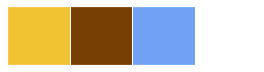

In [172]:
imp.reload(vp)

data = vp.create_chart_xy_components(d = time_data_daily, 
                                  date_time_column = 'date_time', 
                                  start_date = START_DATE, 
                                  end_date = END_DATE, 
                                  category_column = breakdown_level_col)

# Color and Category Selection
(color_palette, 
 category_list_names_ordered, 
 color_pairs_main) = vp.organize_categories_colors(d = data, 
                                                   category_column = breakdown_level_col, 
                                                   colors = None, 
                                                   specified_category_list = None)

sns.palplot(color_palette)
pd.DataFrame(color_pairs_main.items(), columns = ['category', 'color']).sort_values('category')

Colors Resources
- [Color Hex Faves](https://www.color-hex.com/)
- [Color Picker](https://www.w3schools.com/colors/colors_picker.asp)
- [Html color codes](https://htmlcolorcodes.com/)

In [173]:
# # Select only the relevant color pairs
# mc = vp.my_color_schema
# bl = list(data[breakdown_level_col].unique())
# color_pairs_main = {x: mc[x] for x in bl}

# # Enter your own dictionary
# color_pairs_main = {'asleep': '#783f04ff', 'active': '#f1c232ff'}
# # Update a color
# color_pairs_main.update(dict.fromkeys(['active'], '#f1c232ff'))

# category_list_names_ordered = [key for (key, value) in sorted(color_pairs_main.items())]
# color_palette = [value for (key, value) in sorted(color_pairs_main.items())]

# # Print Results table and colors
# sns.palplot(color_palette)
# pd.DataFrame(color_pairs_main.items(), columns = ['category', 'color']).sort_values('category')

In [174]:
import datetime as dt
td = (data['date_time_min'].max() - data['date_time_min'].min())
print(f'{START_DATE} -- {END_DATE}\n({td})')

2021-02-01 -- 2021-02-22
(20 days 02:04:00)


In [175]:
# fsize = 33
# params = {
#     'axes.labelsize': 50, 
#     'axes.titlesize':fsize, 
#     'axes.titlepad': 20,
#     'xtick.labelsize':70,
#     'xtick.major.pad': 5, 
#     'ytick.labelsize':fsize,
#     'axes.labelpad': 30,
#     'lines.linewidth' : 3,
#     'figure.titlesize': fsize *1.5,
#     'figure.figsize' : (16,8),
#     'legend.title_fontsize': fsize,
#     'legend.fontsize': fsize #*0.925, 
# } 
# plt.rcParams.update(params) 
# plt.close('all')

In [176]:
# plt.style.use('default')

In [177]:
# plt.rcParams.update({'ytick.labelsize':25}) 

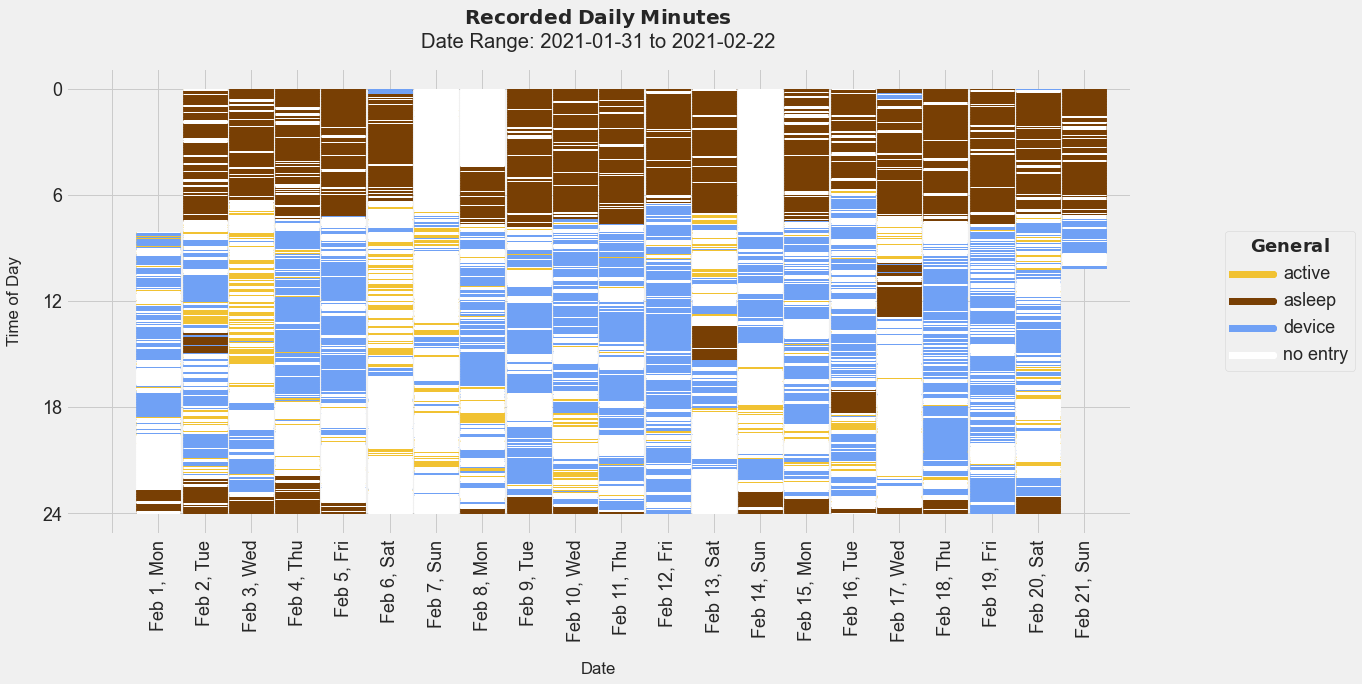

In [178]:
imp.reload(vp)

# Modify the chart width based on the number of days
plt.rcParams.update({'figure.figsize' : (td.days*.85,8)}) 

# Daily Stacked Chart
vp.daily_chart_24_hours(d = data, 
                        category_column = breakdown_level_col,
                        category_list_names_ordered = category_list_names_ordered,
                        color_palette = color_palette, 
                        add_reference_lines = False,
                        top_line = 9, 
                        bottom_line = 17,
                        legend_on = True,
                       turn_xaxis_on = True)

In [180]:
pivot_data = vp.pivot_data_with_missing_days(data = data,
                             specified_category_list = category_list_names_ordered.copy(), #['Design & Composition'] 
                             remove_no_entry_category = 1, 
                             values_column_name = 'duration_minutes',
                             values_hour_conversion = 60,
                             category_column = breakdown_level_col
                            )

In [181]:
print(f'{START_DATE} -- {END_DATE}\n({td})\n')

days, hours, minutes = td.days, td.seconds // 3600, td.seconds % 3600 / 60.0
total_hours = round((td.days * 24) + (td.seconds // 3600) + (td.seconds % 3600 / (60.0 * 60.0)),2)
tracked_hours = round(pivot_data.sum().sum(),2)

data_onl = data[~(data[breakdown_level_col].isin(list(step_time_data['Step Activity'].unique()) + list(sleep_time_data['Sleep Stage'].unique())))]
online_tracked_hours = round(data_onl['duration_minutes'].sum()/60,1)

# Awake Hours
data_inbed = data[(data[breakdown_level_col].isin(list(sleep_time_data['Sleep Stage'].unique())))]
inbed_tracked_hours = round(data_inbed['duration_minutes'].sum()/60,1)


device_usage = {
    'Breakdown': ['Total', 'Tracked', 'Device', 'Device / Awake'],
    'Hours': [total_hours, 
              tracked_hours, 
              online_tracked_hours, 
              online_tracked_hours],
    'Percentage': [100, 
                   round(tracked_hours * 100/ total_hours,2 ), 
                   round(online_tracked_hours * 100/ total_hours,2),
                   round(online_tracked_hours * 100/ (total_hours - inbed_tracked_hours),2) ]
}

du = pd.DataFrame.from_dict(device_usage)
du

2021-02-01 -- 2021-02-22
(20 days 02:04:00)



,Breakdown,Hours,Percentage
0,Total,482.07,100.00
1,Tracked,337.50,70.01
2,Device,150.20,31.16
3,Device / Awake,150.20,74.40


In [182]:
data_onl_day = data_onl.groupby(['date_week'])['duration_minutes'].sum().reset_index()
data_onl_day['hours'] = round(data_onl_day['duration_minutes']/60,2)
data_onl_day[['date_week', 'hours']]

,date_week,hours
0,"2021-02-01, Mon",6.50
1,"2021-02-02, Tue",6.77
2,"2021-02-03, Wed",3.73
3,"2021-02-04, Thu",8.55
4,"2021-02-05, Fri",8.57
5,"2021-02-06, Sat",1.45
6,"2021-02-07, Sun",1.88
7,"2021-02-08, Mon",8.48
8,"2021-02-09, Tue",9.28
9,"2021-02-10, Wed",8.53


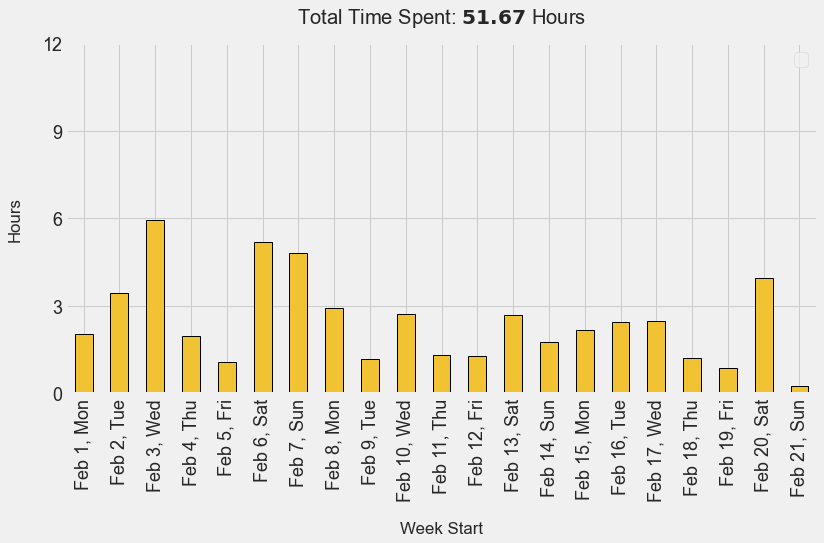

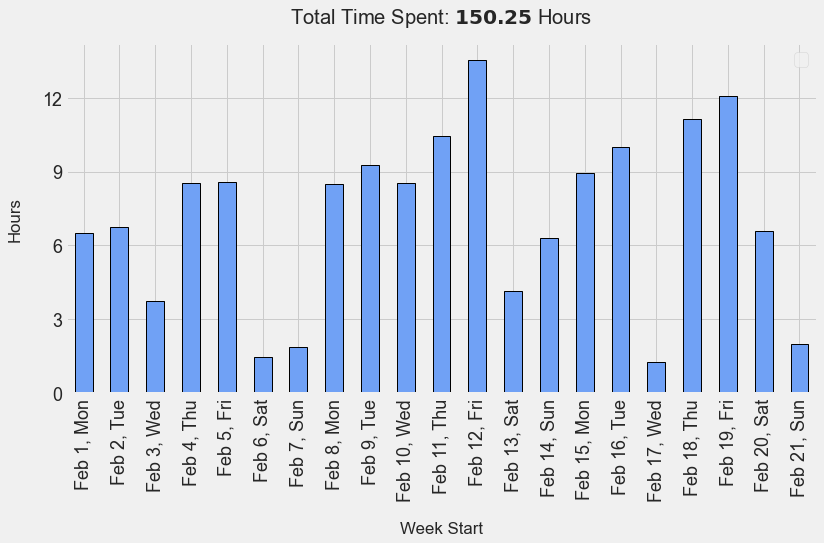

In [183]:
imp.reload(vp)

for i in ['active', 'device']:
    vp.stacked_bar_chart_categories(pivot_data = pivot_data[[i]], 
                                    color_pairs = color_pairs_main,
                                    legend_on = False,
                                    ymax = 13, ystep = 3)

## Explore: Sleep

In [184]:
breakdown_level_col = 'Sleep Details'

,category,color
3,asleep,#783f04ff
2,awake,#7fffd4
4,no entry,#ffffff
1,other,#e8e8e8
0,restless,#ffccf2


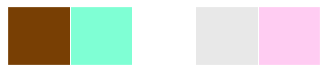

In [185]:
imp.reload(vp)

data = vp.create_chart_xy_components(d = time_data_daily, 
                                  date_time_column = 'date_time', 
                                  start_date = START_DATE, 
                                  end_date = END_DATE, 
                                  category_column = breakdown_level_col)

# Color and Category Selection
(color_palette, 
 category_list_names_ordered, 
 color_pairs_main) = vp.organize_categories_colors(d = data, 
                                                   category_column = breakdown_level_col, 
                                                   colors = None, 
                                                   specified_category_list = None)

sns.palplot(color_palette)
pd.DataFrame(color_pairs_main.items(), columns = ['category', 'color']).sort_values('category')

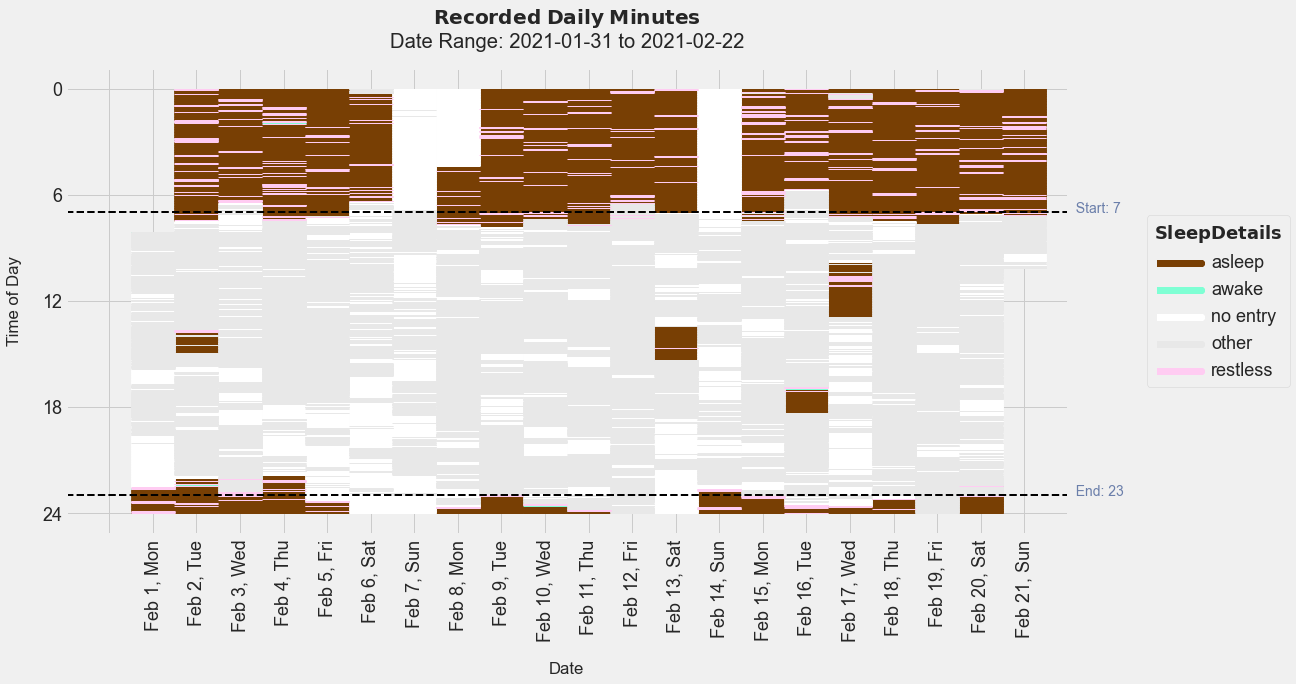

In [186]:
imp.reload(vp)
# Visualize
vp.daily_chart_24_hours(d = data, 
                        category_column = breakdown_level_col, #'Detail', #'Sleep Activity', 
                        category_list_names_ordered = category_list_names_ordered,
                        color_palette = color_palette, 
                        add_reference_lines = True,
                        top_line = 7, 
                        bottom_line = 23,
                        legend_on = True,
                       turn_xaxis_on = True)

In [200]:
# Actual Time Ajustment - backwards
time_data_shifted = time_data_daily.copy()
time_data_shifted['Time'] = time_data_shifted['date_time_min'].dt.strftime('%H:M:S')

# Use 9pm as the cutoff 
for date_time_x in ['date_time', 'Date Start', 'date_time_min']:
    time_data_shifted[date_time_x] = np.where((time_data_shifted['Time'] >= '21:00:00') & (time_data_shifted['Time'] < '24:00:00'), 
                                     time_data_shifted[date_time_x] + pd.DateOffset(days=1), 
                                     time_data_shifted[date_time_x])


In [201]:
data = vp.create_chart_xy_components(d = time_data_shifted, 
                                  date_time_column = 'date_time', 
                                  start_date = START_DATE, 
                                  end_date = END_DATE, 
                                  category_column = breakdown_level_col)

In [194]:
pivot_data = vp.pivot_data_with_missing_days(data = data[data[breakdown_level_col].isin(['asleep','restless','awake'])],
                             specified_category_list = category_list_names_ordered.copy(), #['asleep', 'no entry']
                             remove_no_entry_category = 1, 
                             values_column_name = 'duration_minutes',
                             values_hour_conversion = 60,
                             category_column = breakdown_level_col
                            )

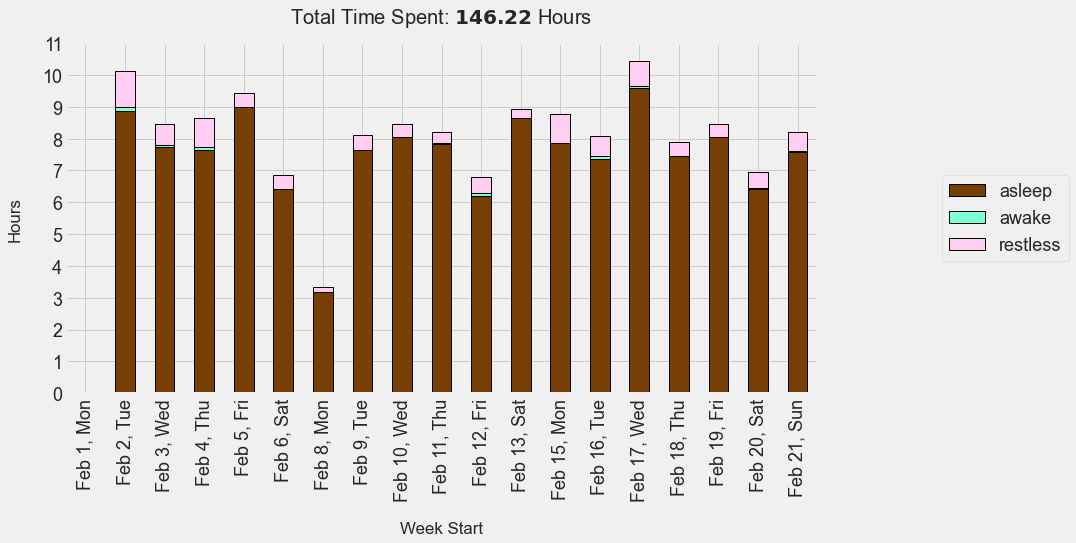

In [195]:
vp.stacked_bar_chart_categories(pivot_data = pivot_data, 
                                color_pairs = color_pairs_main,
                                legend_on = 1,
                                ymax = 12, ystep = 1)

**Plot hours slept in the middle to see how consistent my sleep times are at night and morning**

In [224]:
# Actual Time Ajustment - backwards
time_data_shifted = time_data_daily.copy()
time_data_shifted['Time'] = time_data_shifted['date_time_min'].dt.strftime('%H:M:S')

# Use 9pm as for one nights sleep AND reverse times 
for date_time_x in ['date_time', 'Date Start', 'date_time_min']:
    # Step 1: Get 'one' nights of sleep
    time_data_shifted[date_time_x] = np.where((time_data_shifted['Time'] >= '21:00:00') & (time_data_shifted['Time'] < '24:00:00'), 
                                     time_data_shifted[date_time_x] + pd.DateOffset(days=1), 
                                     time_data_shifted[date_time_x])                                              
    # Step 2: Flip times so that chart center is midnight    
    time_data_shifted[date_time_x] = np.where((time_data_shifted['Time'] >= '12:00:00') & (time_data_shifted['Time'] < '24:00:00'), 
                                    time_data_shifted[date_time_x] + dt.timedelta(hours=12) - dt.timedelta(days=1), # Update only the hours
                                    time_data_shifted[date_time_x] - dt.timedelta(hours=12)
    )


In [223]:
time_data_daily['date_time'][500] - dt.timedelta(hours=12)

Timestamp('2021-02-01 04:25:58')

In [219]:
time_data_daily['date_time'][1000]

Timestamp('2021-02-02 00:45:58')

In [230]:
time_data_daily['date_time'][500]

Timestamp('2021-02-01 16:25:58')

In [231]:
time_data_daily['date_time'][500] + dt.timedelta(hours=12) - dt.timedelta(days=1)

Timestamp('2021-02-01 04:25:58')

In [232]:
data = vp.create_chart_xy_components(d = time_data_shifted, 
                                  date_time_column = 'date_time', 
                                  start_date = START_DATE, 
                                  end_date = END_DATE, 
                                  category_column = breakdown_level_col)

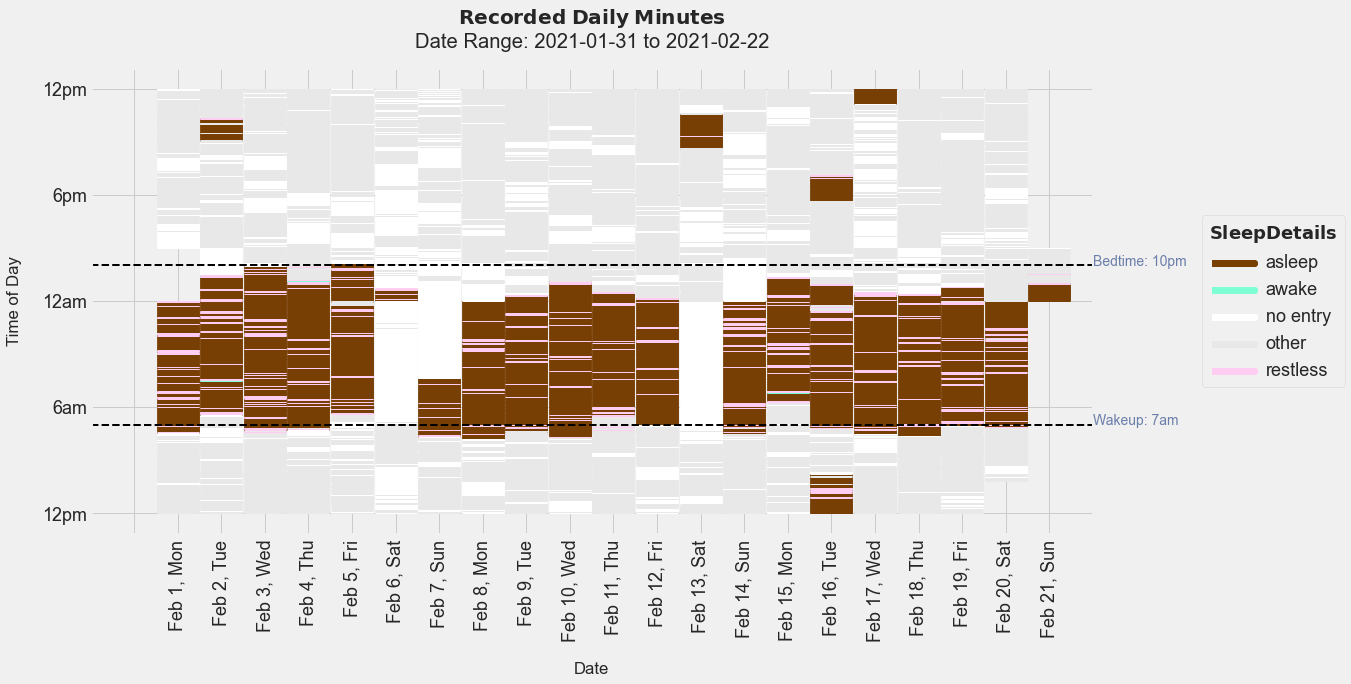

In [275]:
imp.reload(vp)
# Visualize
vp.daily_chart_24_hours(d = data, 
                        category_column = breakdown_level_col, #'Detail', #'Sleep Activity', 
                        category_list_names_ordered = category_list_names_ordered,
                        color_palette = color_palette, 
                        add_reference_lines = True,
                        top_line = 10, 
                        bottom_line = 24-5,
                        legend_on = True,
                       turn_xaxis_on = True,
                       new_yaxis_labels = ['12pm', '6pm','12am', '6am' , '12pm'],
                       new_ref_line_text = ['Bedtime: 10pm', 'Wakeup: 7am']
                       )

## Explore: Device Usage

In [276]:
breakdown_level_col = 'Detail'

In [277]:
imp.reload(vp)

data = vp.create_chart_xy_components(d = time_data_daily, 
                                  date_time_column = 'date_time', 
                                  start_date = START_DATE, 
                                  end_date = END_DATE, 
                                  category_column = breakdown_level_col)

# Color and Category Selection
(color_palette, 
 category_list_names_ordered, 
 color_pairs_main) = vp.organize_categories_colors(d = data, 
                                                   category_column = breakdown_level_col, 
                                                   colors = None, 
                                                   specified_category_list = None)

# sns.palplot(color_palette)
# pd.DataFrame(color_pairs_main.items(), columns = ['category', 'color']).sort_values('category')

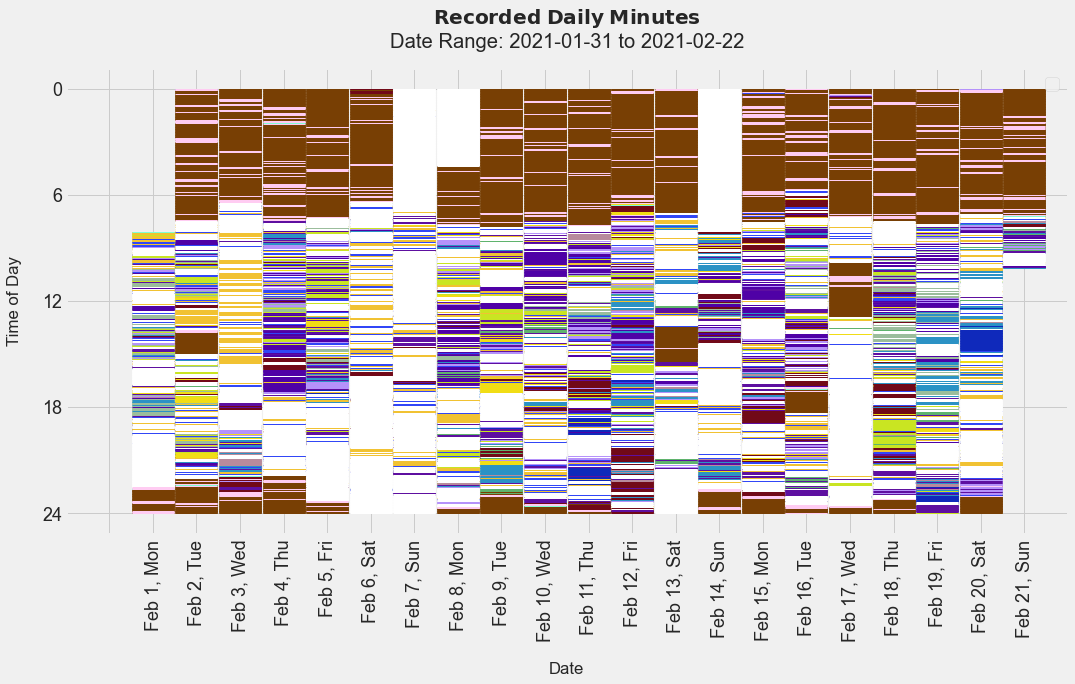

In [278]:
# Visualize
vp.daily_chart_24_hours(d = data, 
                        category_column = breakdown_level_col, #'Detail', #'Sleep Activity', 
                        category_list_names_ordered = category_list_names_ordered,
                        color_palette = color_palette, 
                        add_reference_lines = False,
                        top_line = 9, 
                        bottom_line = 17,
                        legend_on = False,
                       turn_xaxis_on = True)

In [279]:
pivot_data = vp.pivot_data_with_missing_days(data = data,
                             specified_category_list = category_list_names_ordered.copy(), #['Design & Composition'] 
                             remove_no_entry_category = 1, 
                             values_column_name = 'duration_minutes',
                             values_hour_conversion = 60,
                             category_column = breakdown_level_col
                            )

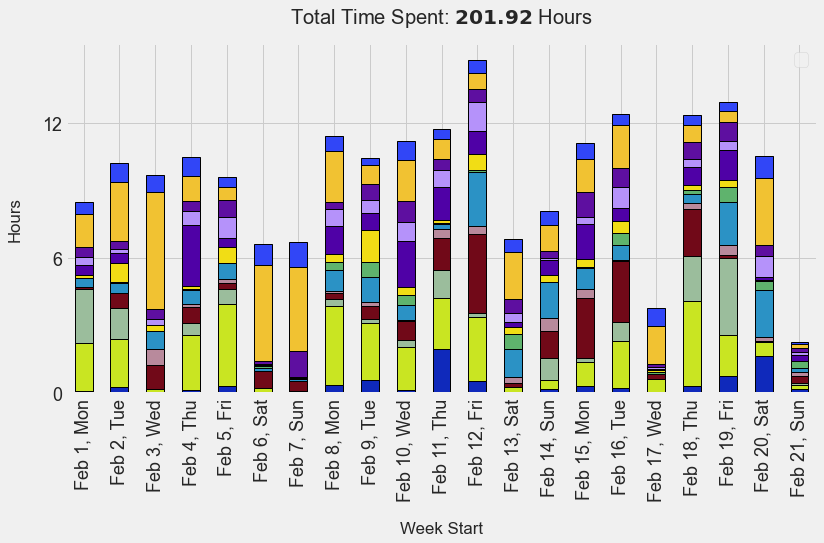

In [283]:
vp.stacked_bar_chart_categories(pivot_data = pivot_data.drop(['asleep','restless','awake'], axis=1), 
                                color_pairs = color_pairs_main,
                                legend_on = False,
                                ymax = 18, ystep = 6)

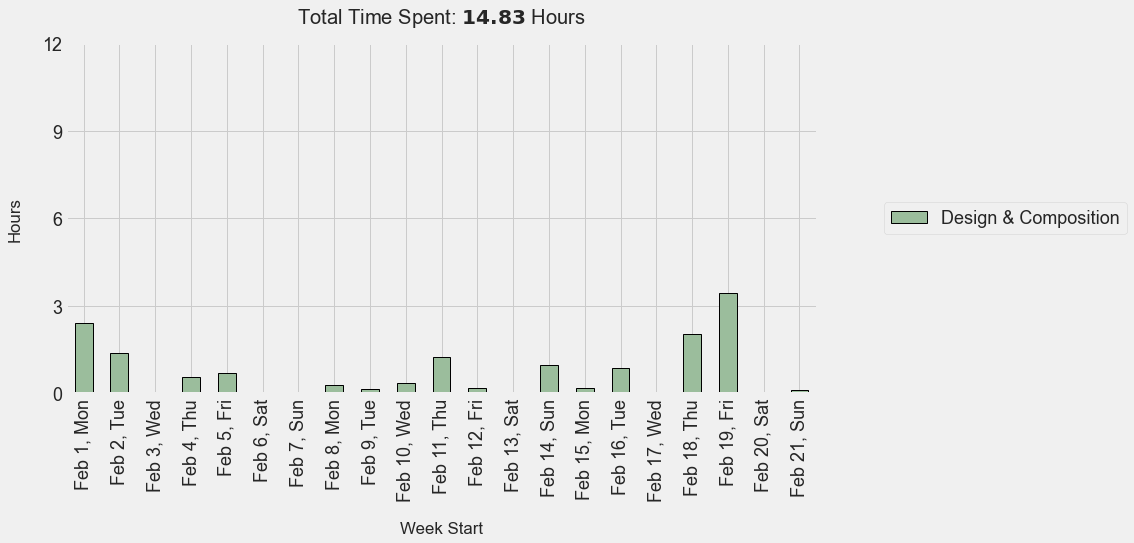

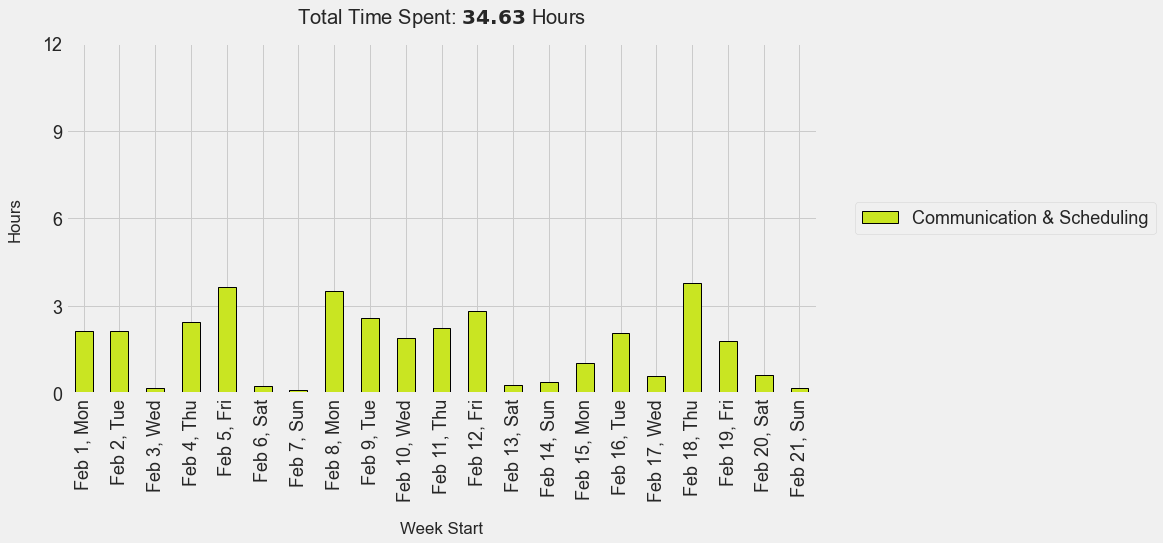

In [281]:
for i in ['Design & Composition', 'Communication & Scheduling']:
    vp.stacked_bar_chart_categories(pivot_data = pivot_data[[i]], 
                                    color_pairs = color_pairs_main,
                                    legend_on = 1,
                                    ymax = 13, ystep = 3)

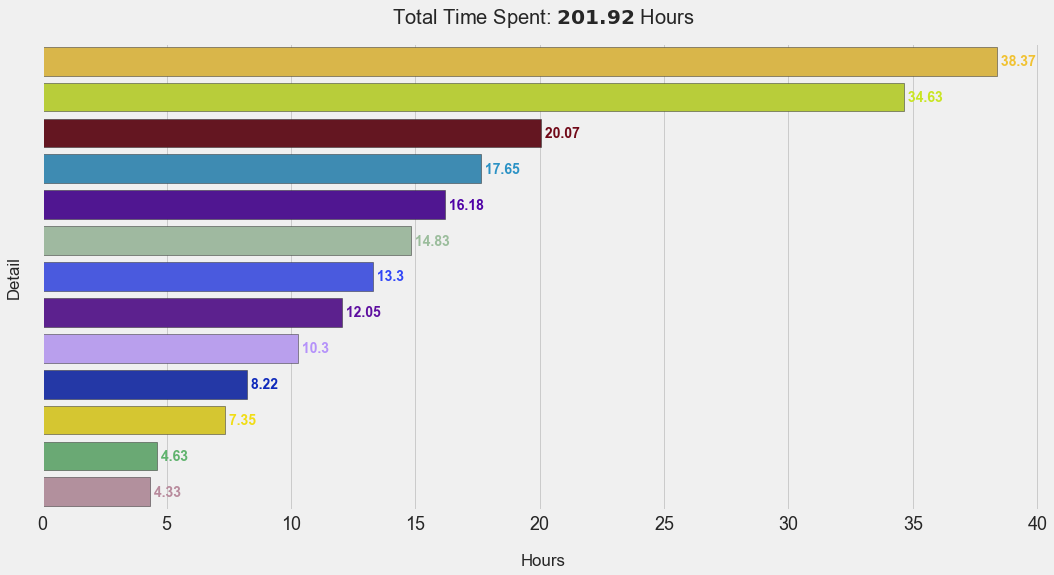

In [282]:
imp.reload(vp)

vp.horizontal_bar_chart_totals(pivot_data = pivot_data.drop(['asleep','restless','awake'], axis=1), 
                               num_categories = 20,
                               color_pairs =  color_pairs_main, 
                               category_column = breakdown_level_col,
                               ytick_labels_on = False)